In [3]:
# 假想一个模型，'著名画家'画的是在一个上下界之间的完美平滑曲线，我们需要模拟画出这样的好的曲线
# 新手画家和新手鉴赏家都是一个NN，著名画家是已知的好的作品家
import torch
import torch.nn as nn

import numpy as np
import matplotlib.pyplot as plt

torch.manual_seed(1)
np.random.seed(1)

In [17]:
# hyper parameters
BATCH_SIZE = 64
LR_G = 0.0001           # learning rate for generator
LR_D = 0.0001           # learning rate for discriminator
N_IDEAS = 5             # think of this as number of ideas for generating an art work (Generator) #灵感的个数
ART_COMPONENTS = 15     # it could be total point G can draw in the canvas   #一条一元二次曲线（这幅画）的点个数
PAINT_POINTS = np.vstack([np.linspace(-1, 1, ART_COMPONENTS) for _ in range(BATCH_SIZE)])  #一整批的画的点都规定了

#print(PAINT_POINTS)
#print(PAINT_POINTS.shape)

(64, 15)


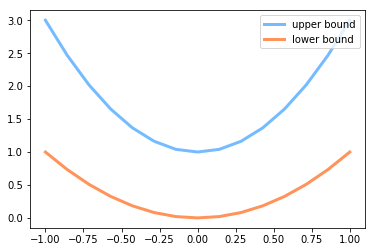

In [30]:
# show our ideal painting range
plt.plot(PAINT_POINTS[0], 2 * np.power(PAINT_POINTS[0], 2) + 1, c='#74BCFF', lw=3, label='upper bound')
plt.plot(PAINT_POINTS[0], 1 * np.power(PAINT_POINTS[0], 2) + 0, c='#FF9359', lw=3, label='lower bound')
plt.legend(loc='upper right')
plt.show()

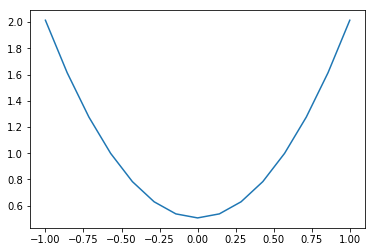

In [26]:
# 著名画家的作品（理想作品）
def artist_works():     # painting from the famous artist (real target)
    a = np.random.uniform(1, 2, size=BATCH_SIZE)[:, np.newaxis]          # shape (64,1)   range(1,2)
    paintings = a * np.power(PAINT_POINTS, 2) + (a-1)            #对比之前的upper和lower bound，发现这个paintings一定在他们中间
    paintings = torch.from_numpy(paintings).float()              #从np转换成torch的形式
    return paintings

# trial
paintings = artist_works()
plt.plot(PAINT_POINTS[0],paintings[1].numpy())

In [44]:
# 定义新手画家       # define generator
G = nn.Sequential(
    nn.Linear(N_IDEAS,128),
    nn.ReLU(),
    nn.Linear(128,ART_COMPONENTS),
)

#定义新手鉴赏家      # define discriminator
D = nn.Sequential(
    nn.Linear(ART_COMPONENTS,128),
    nn.ReLU(),
    nn.Linear(128,1),          #输出的dim为1，判断是不是著名的画
    nn.Sigmoid(),              #化为百分比形式
)

opt_D = torch.optim.Adam(D.parameters(),lr=LR_D)
opt_G = torch.optim.Adam(G.parameters(),lr=LR_G)

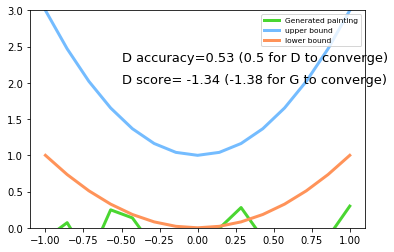

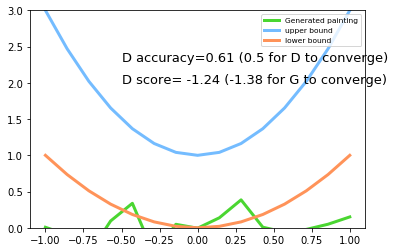

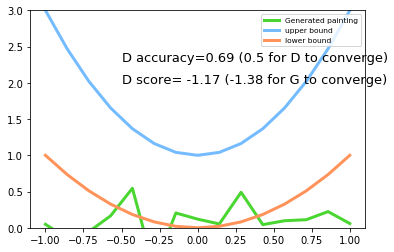

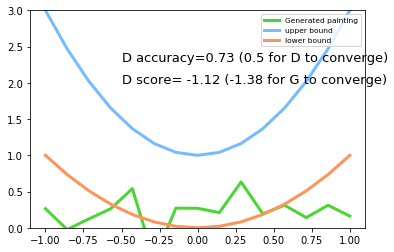

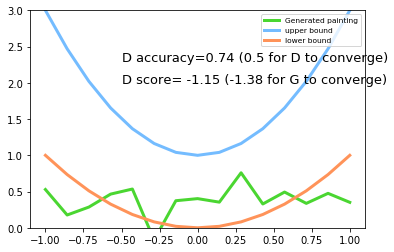

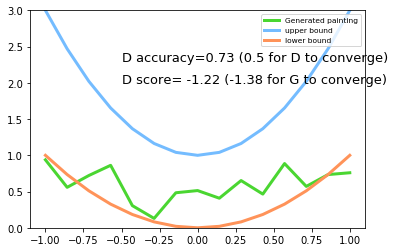

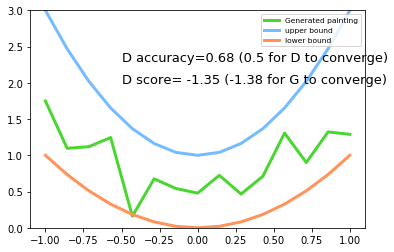

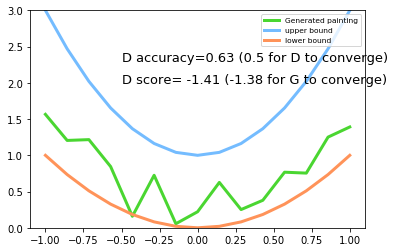

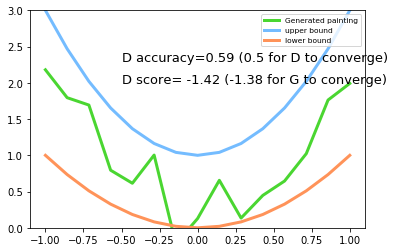

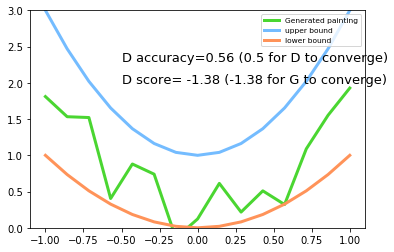

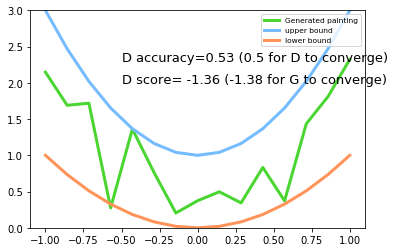

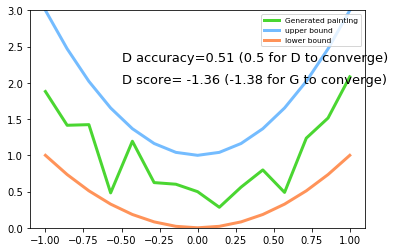

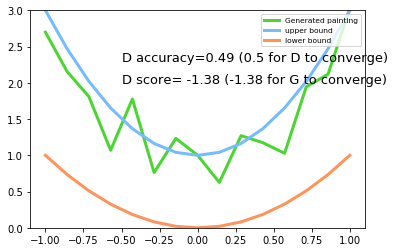

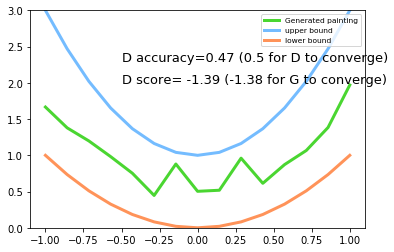

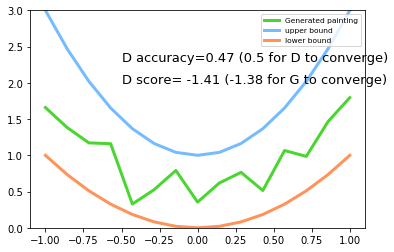

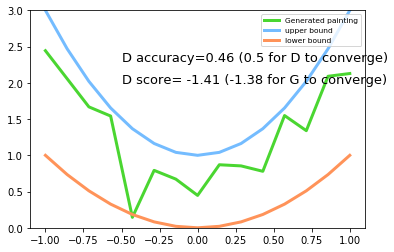

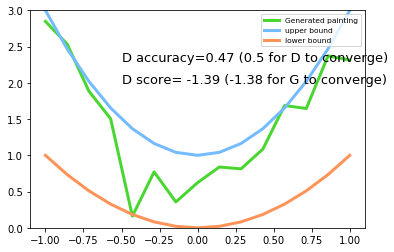

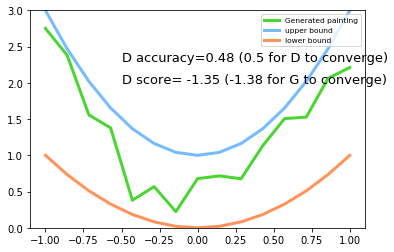

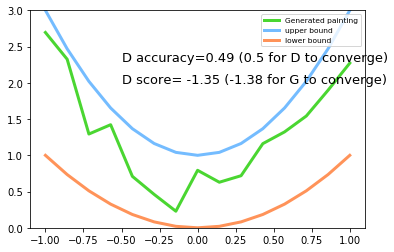

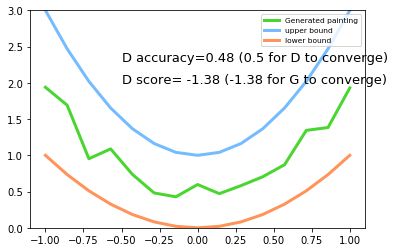

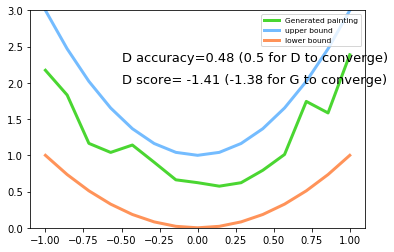

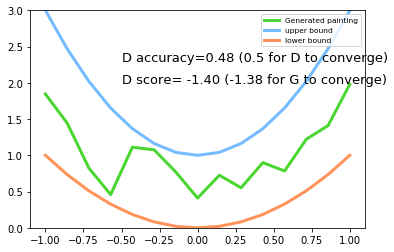

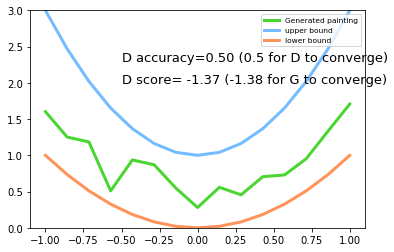

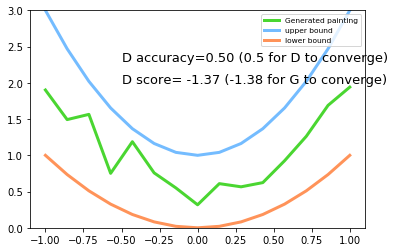

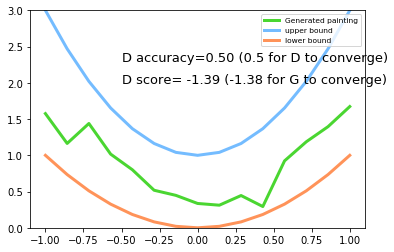

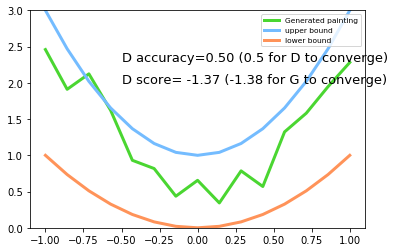

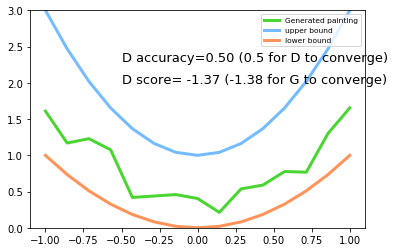

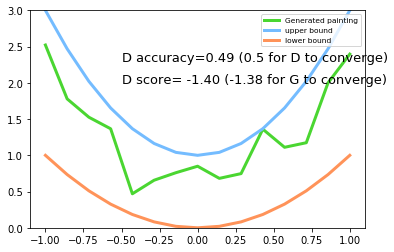

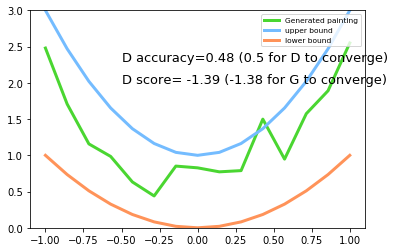

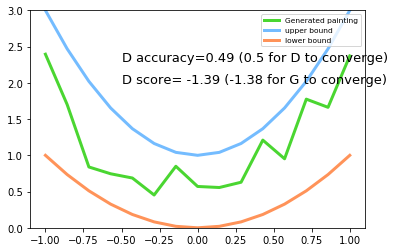

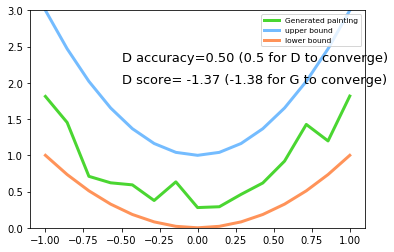

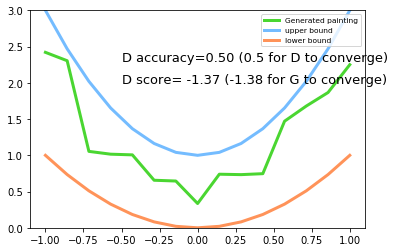

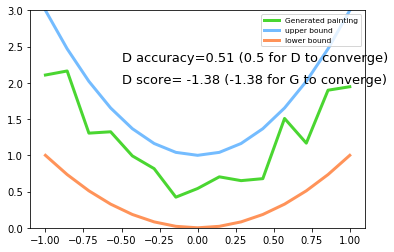

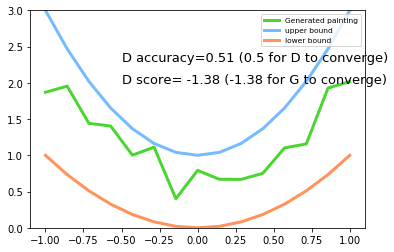

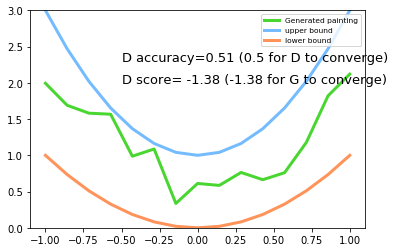

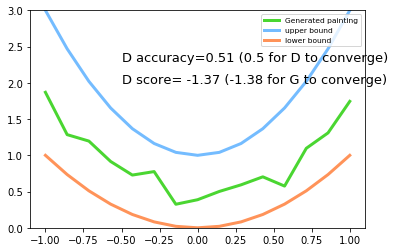

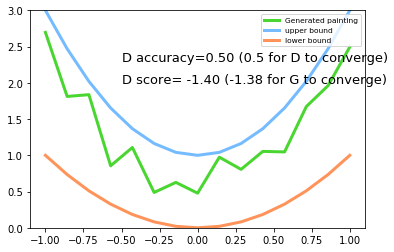

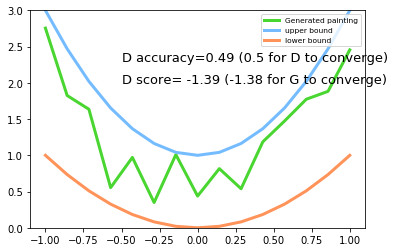

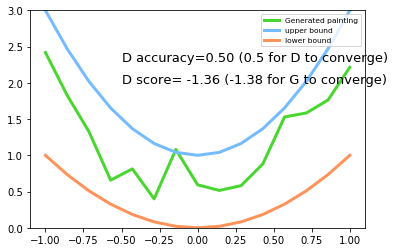

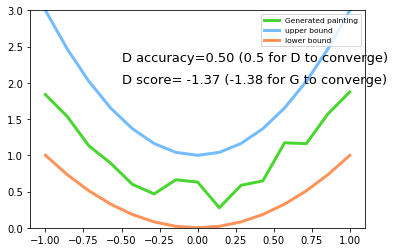

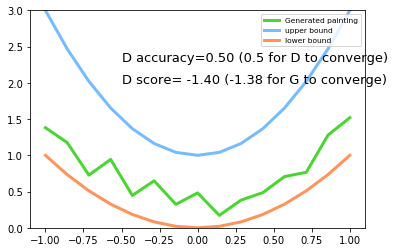

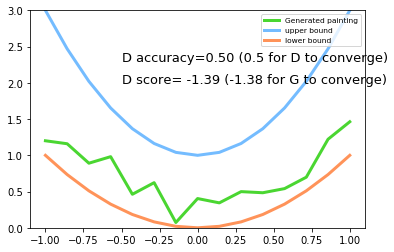

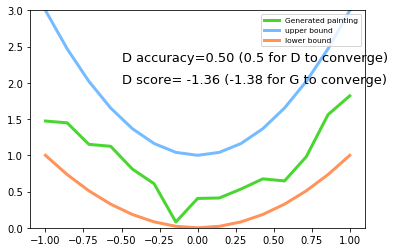

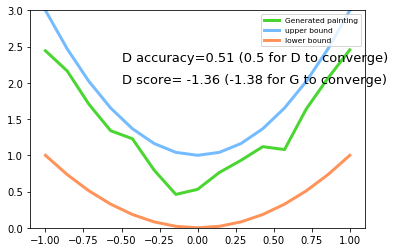

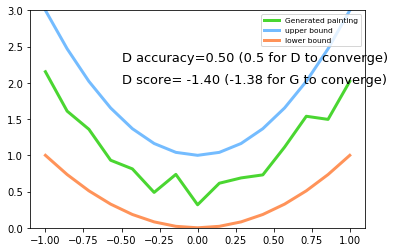

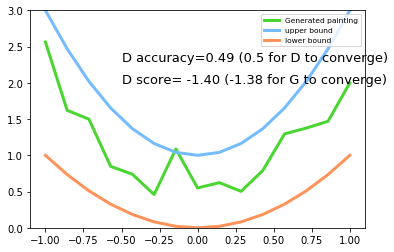

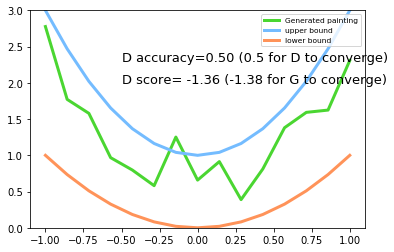

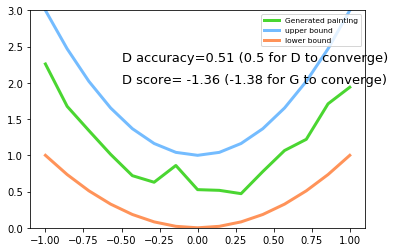

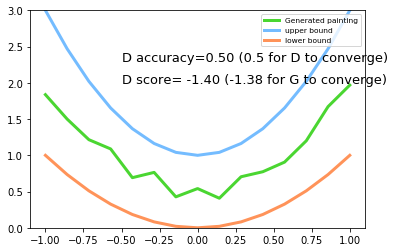

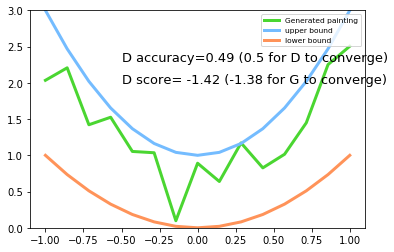

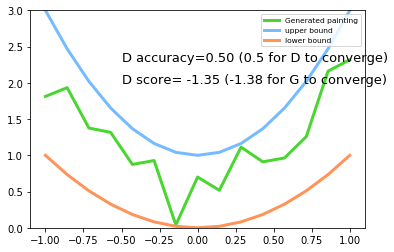

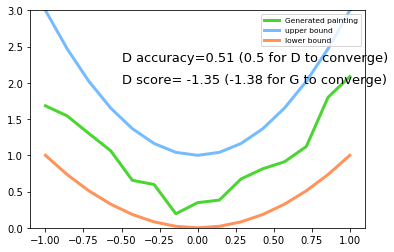

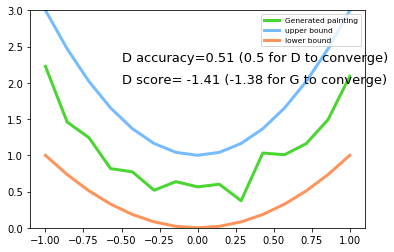

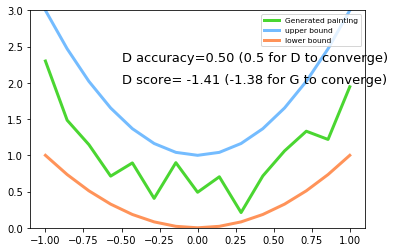

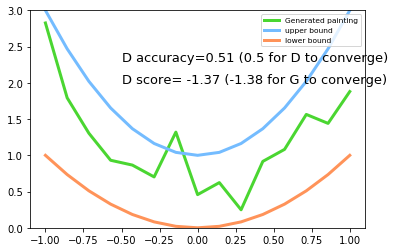

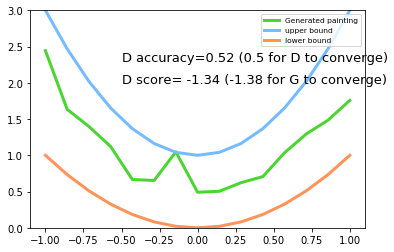

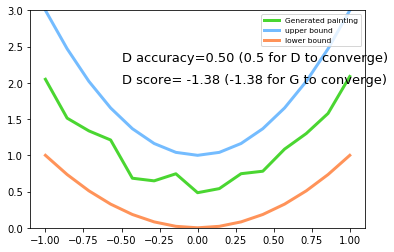

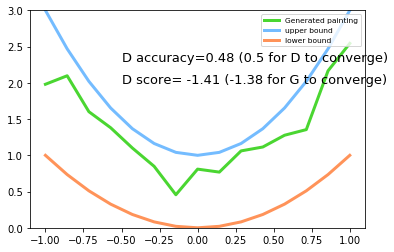

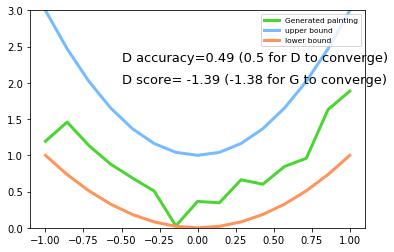

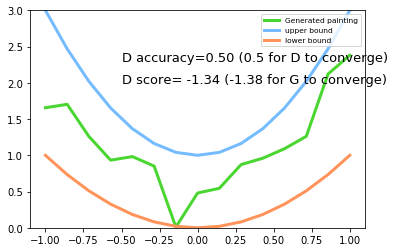

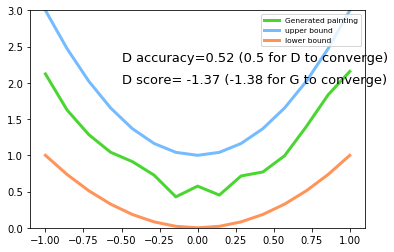

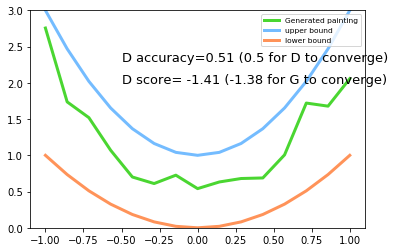

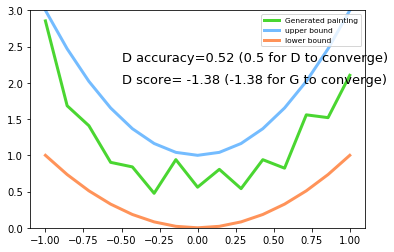

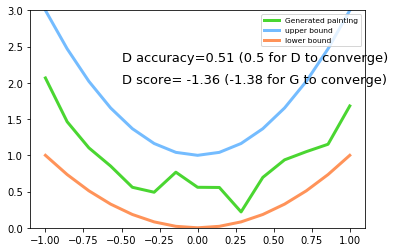

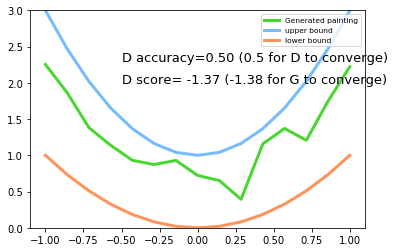

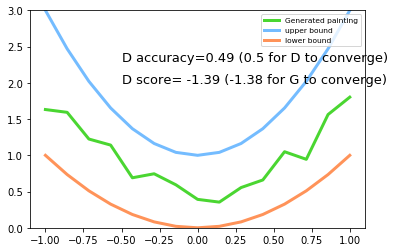

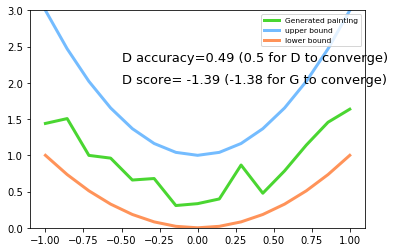

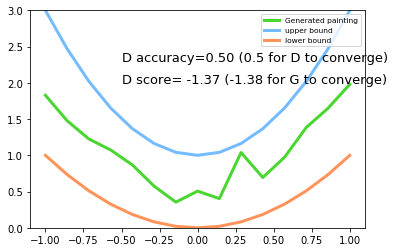

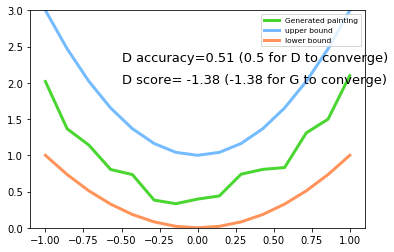

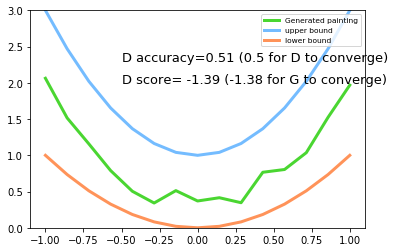

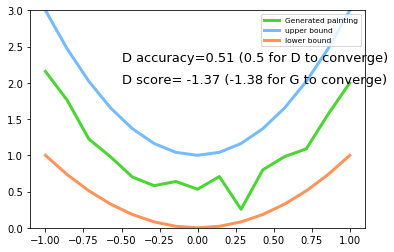

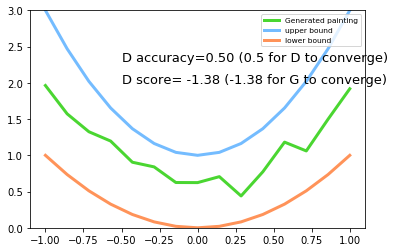

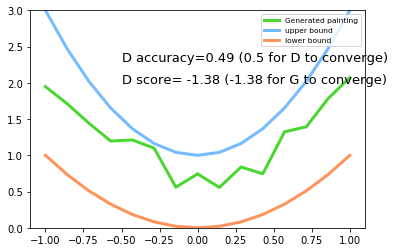

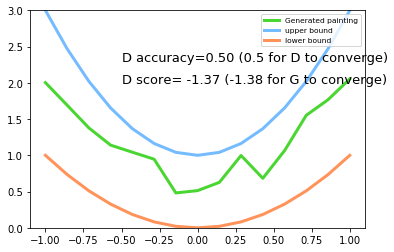

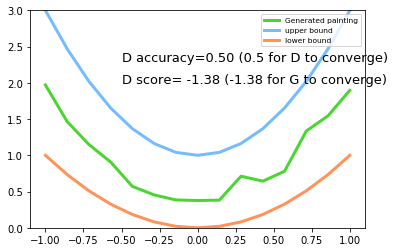

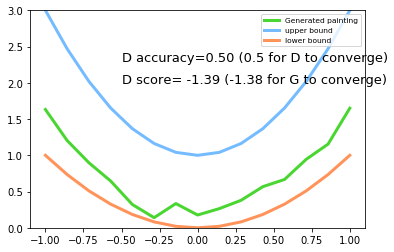

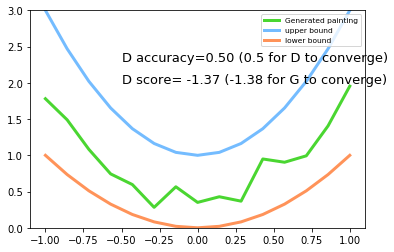

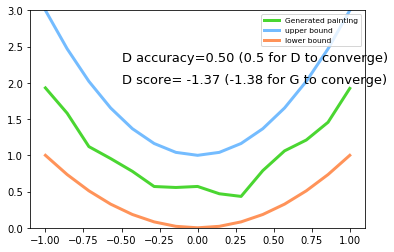

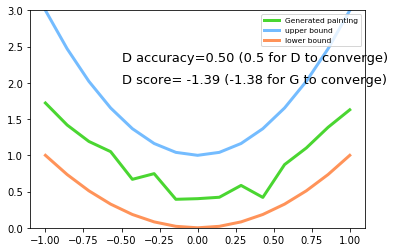

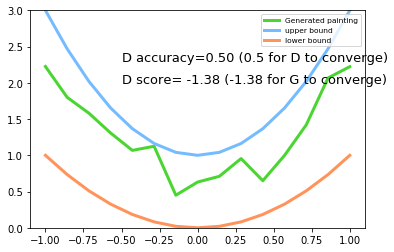

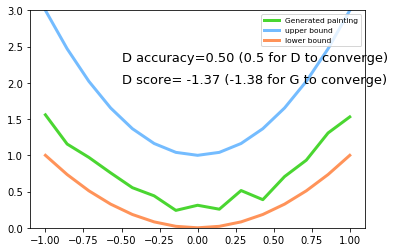

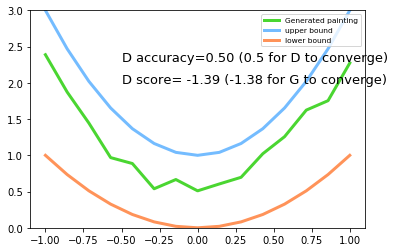

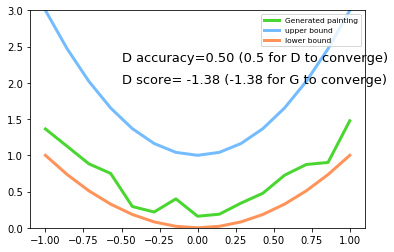

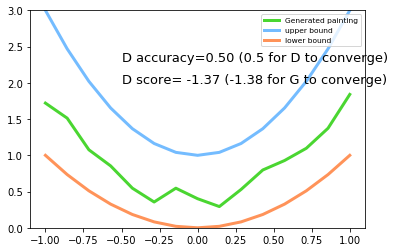

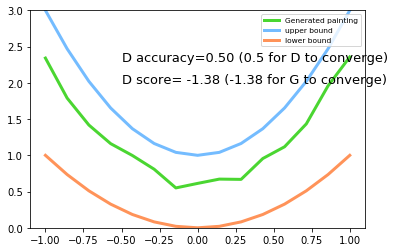

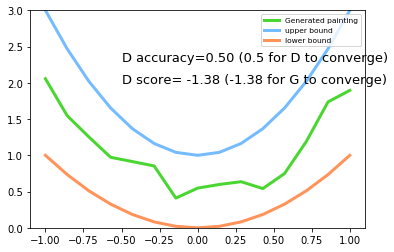

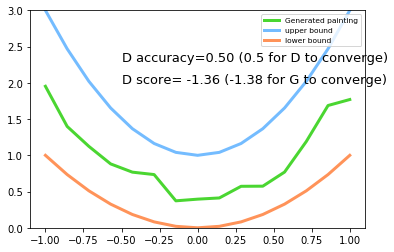

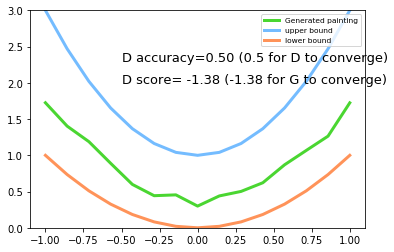

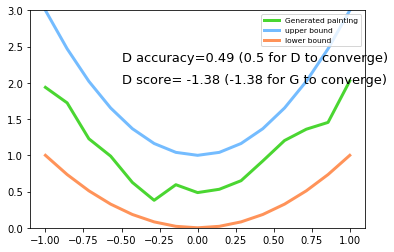

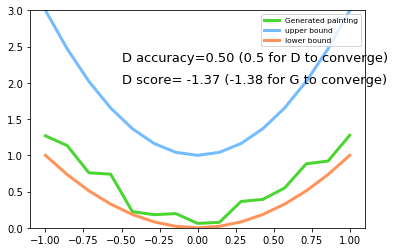

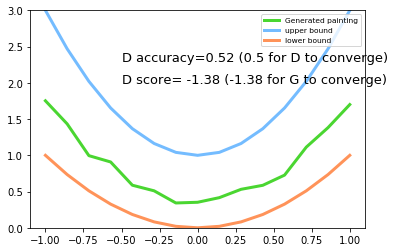

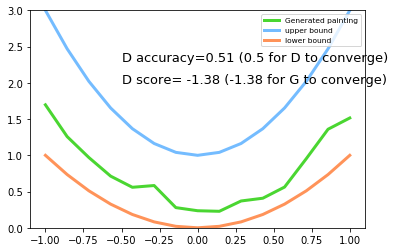

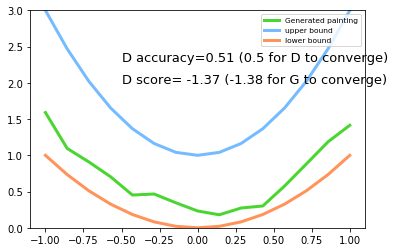

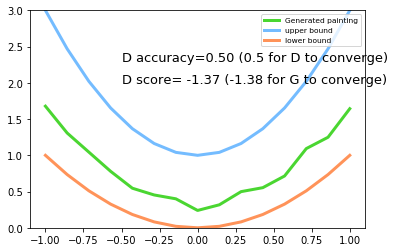

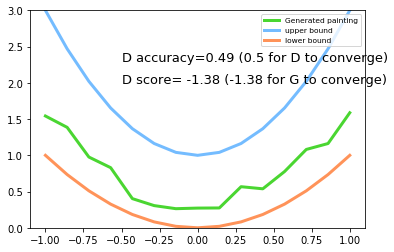

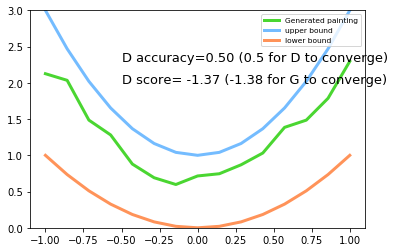

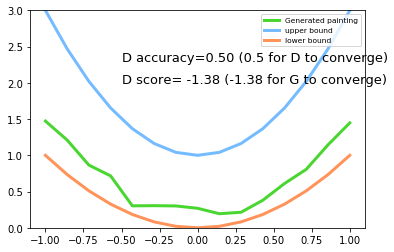

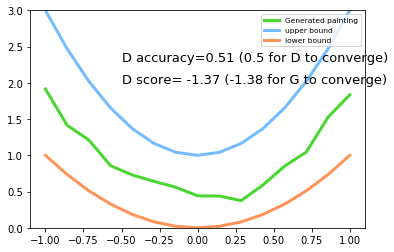

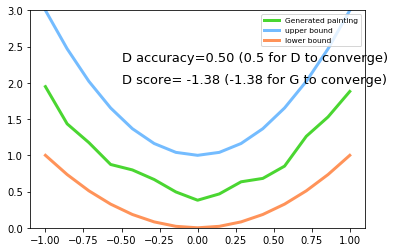

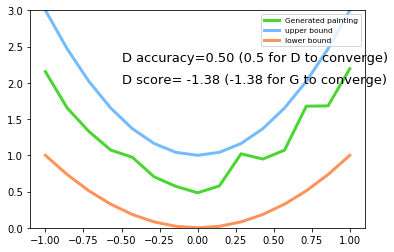

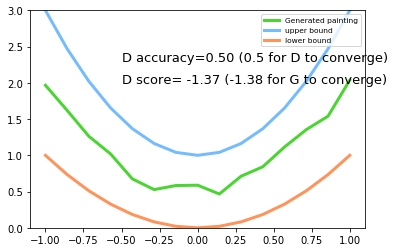

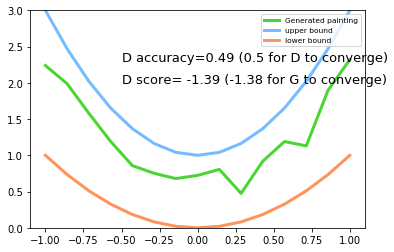

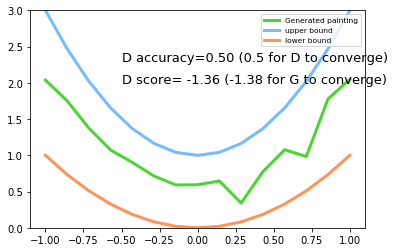

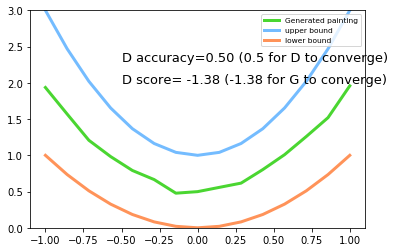

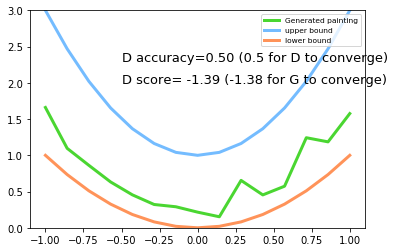

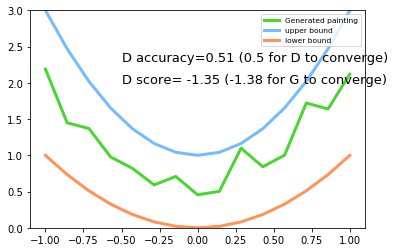

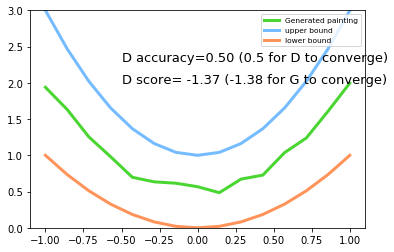

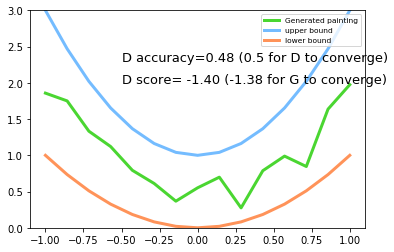

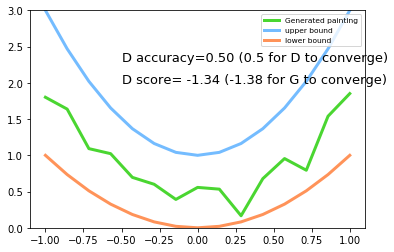

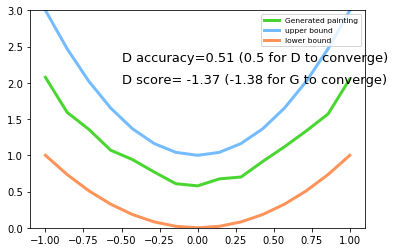

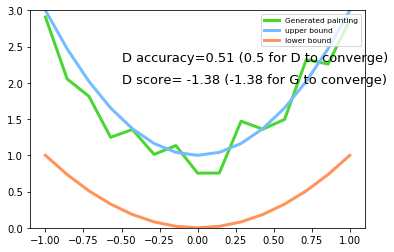

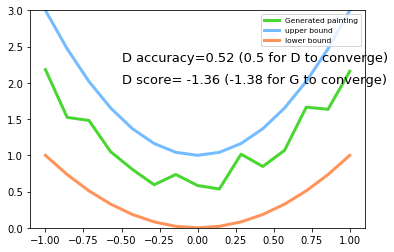

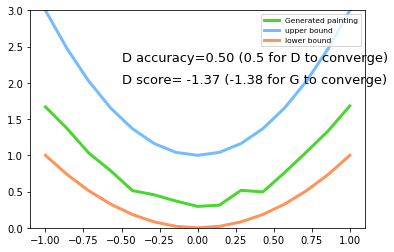

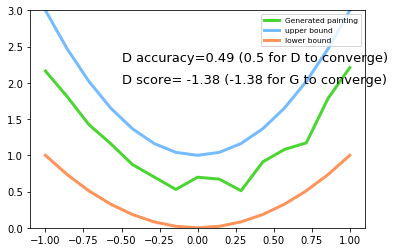

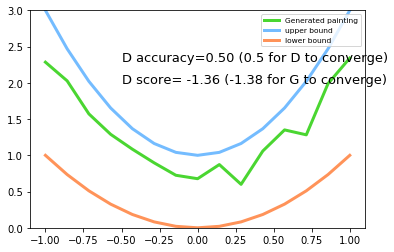

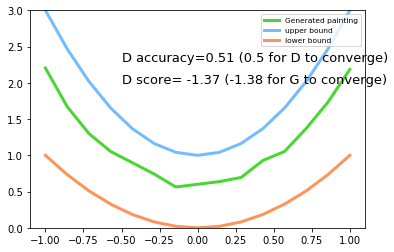

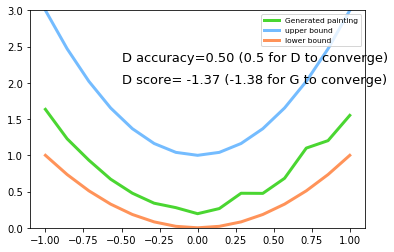

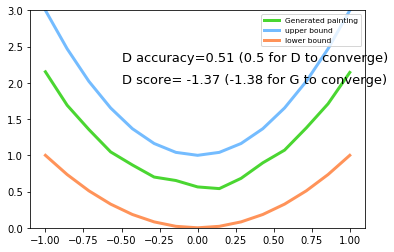

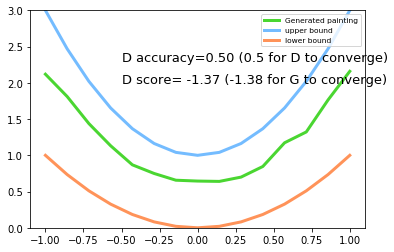

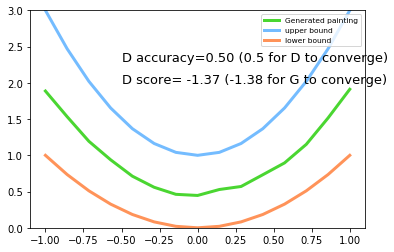

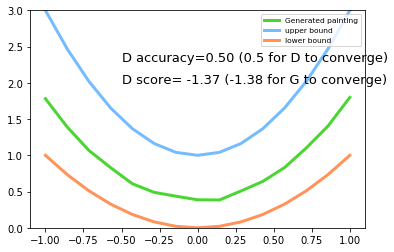

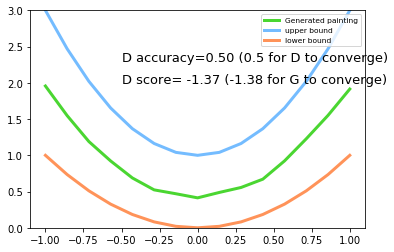

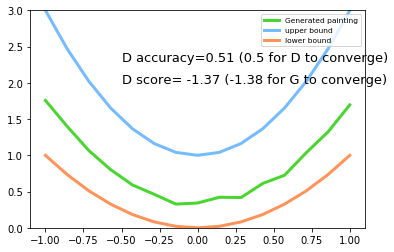

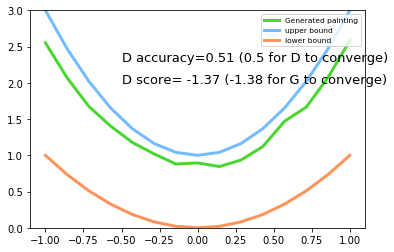

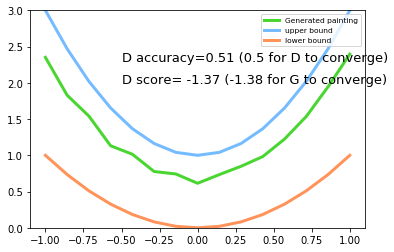

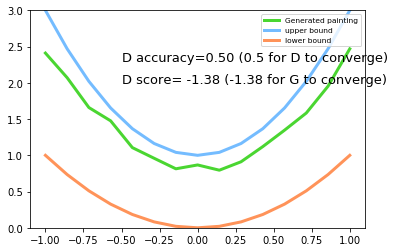

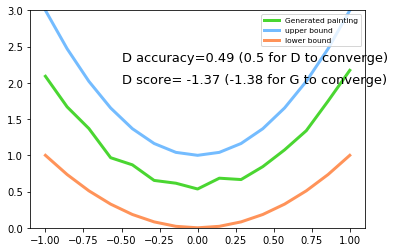

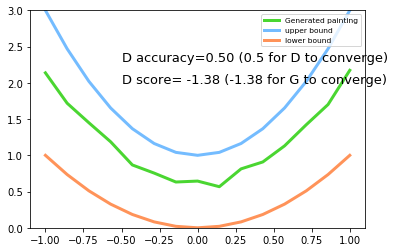

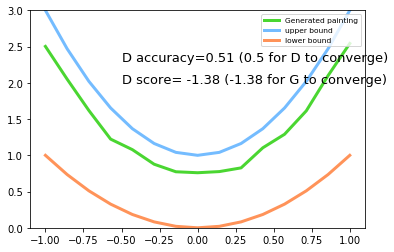

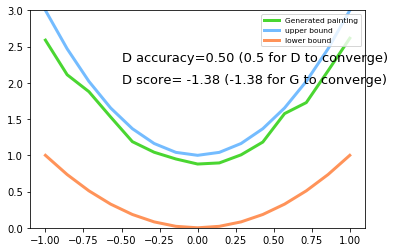

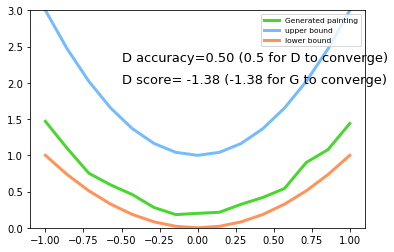

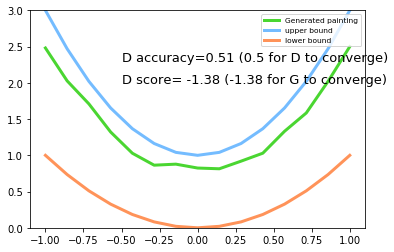

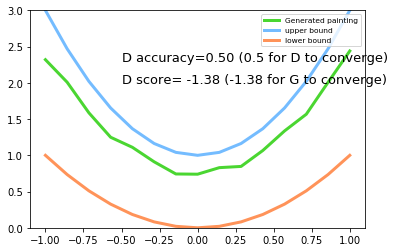

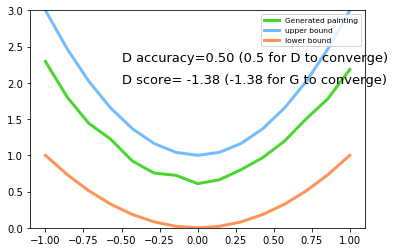

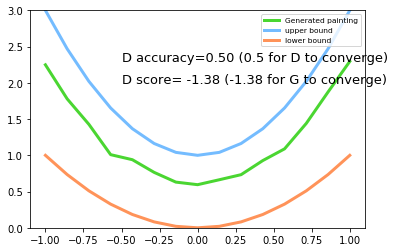

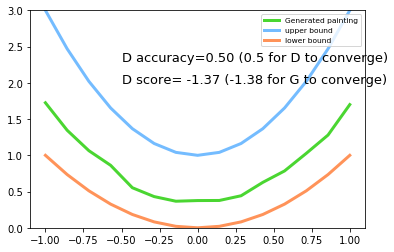

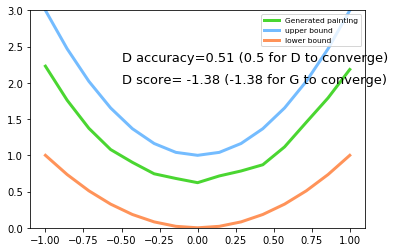

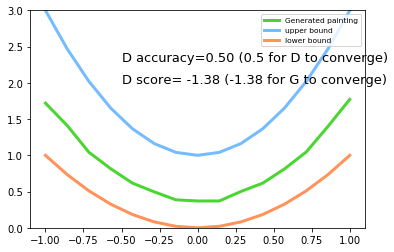

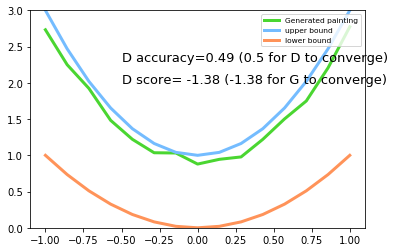

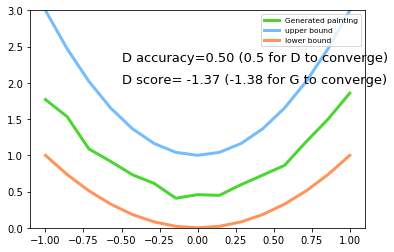

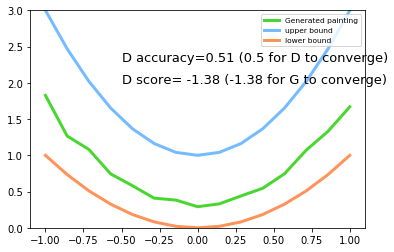

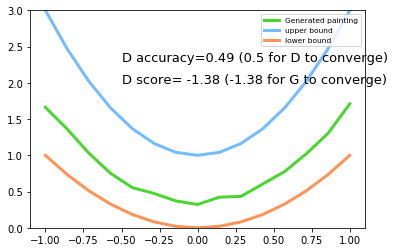

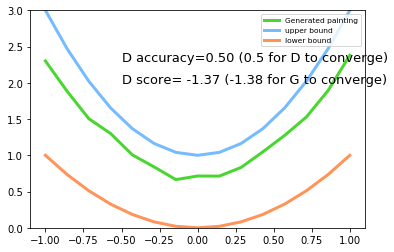

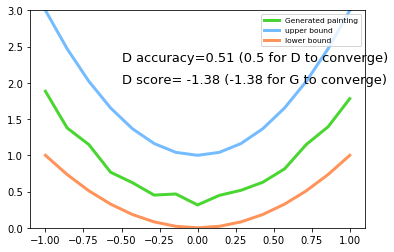

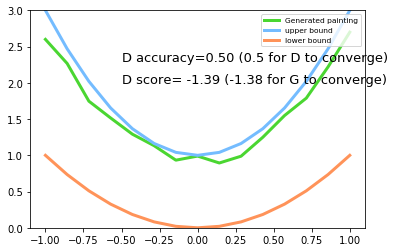

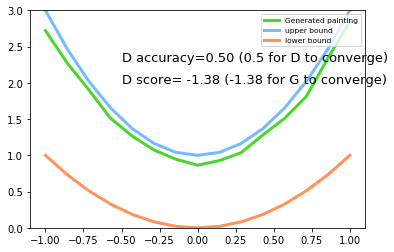

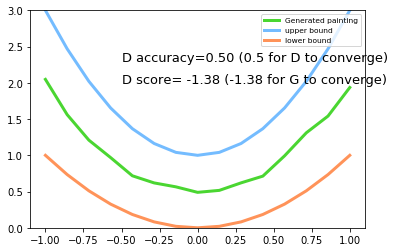

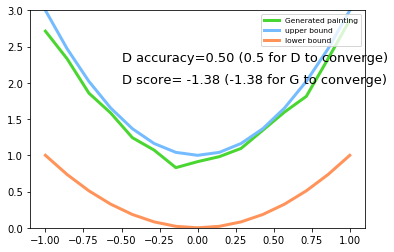

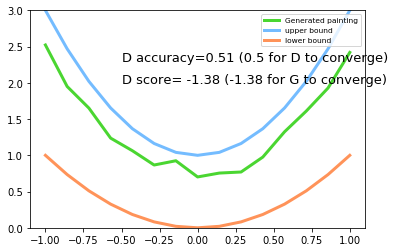

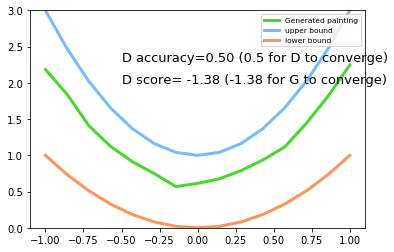

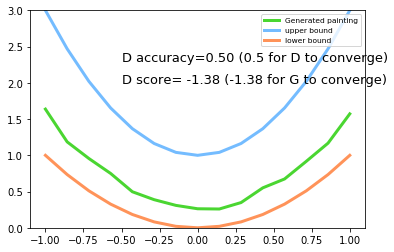

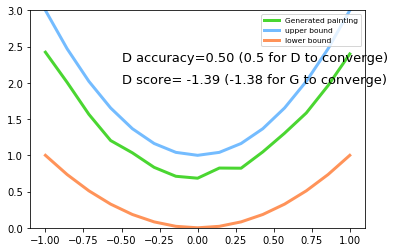

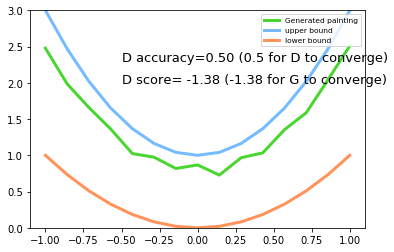

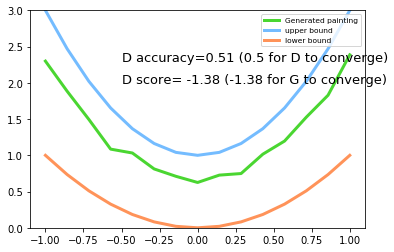

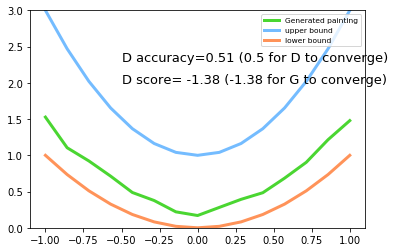

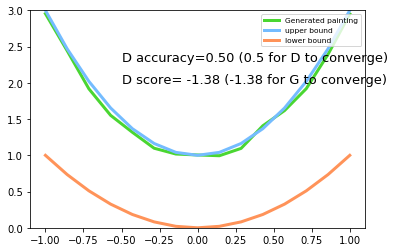

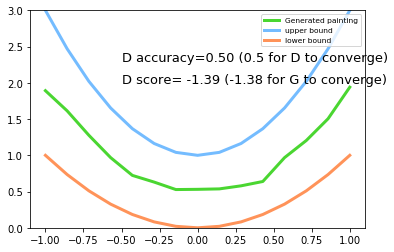

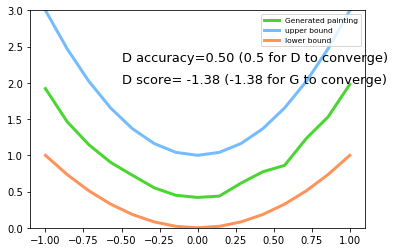

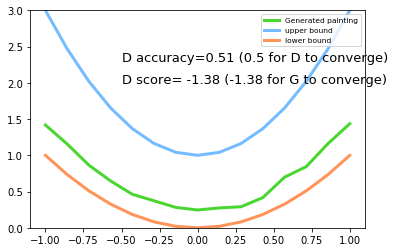

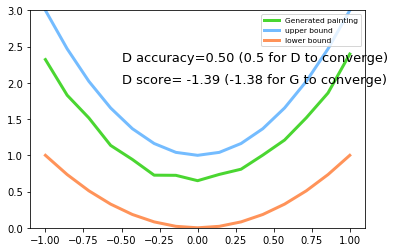

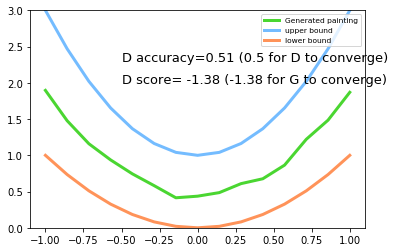

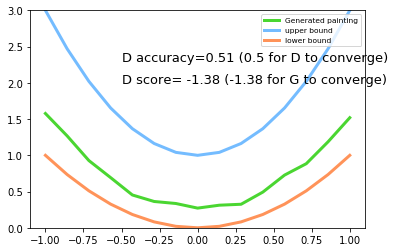

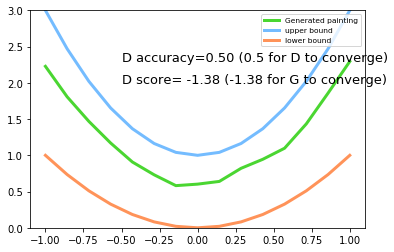

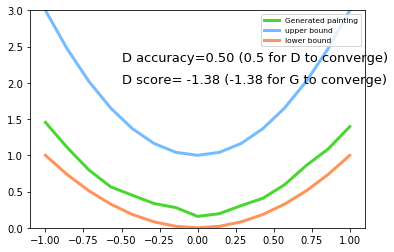

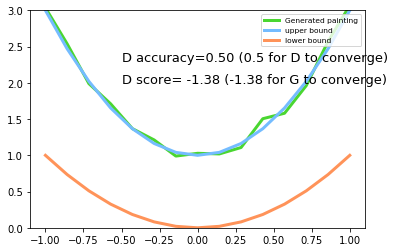

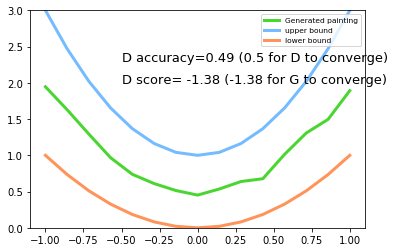

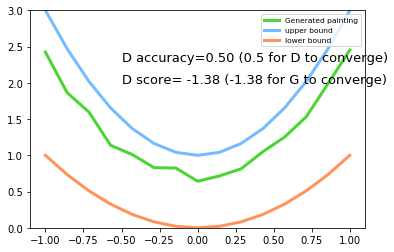

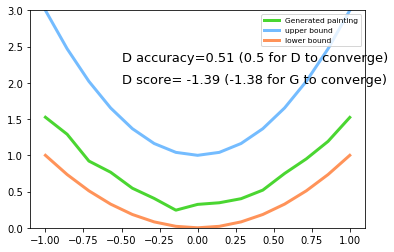

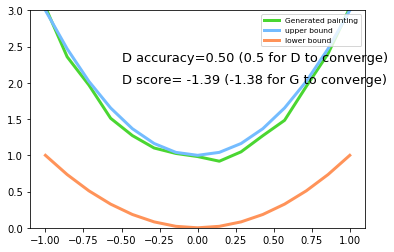

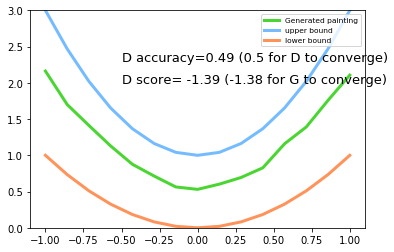

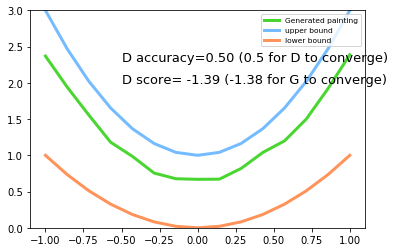

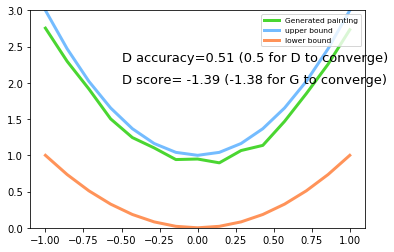

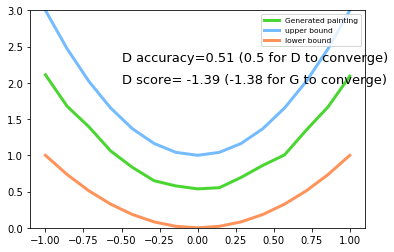

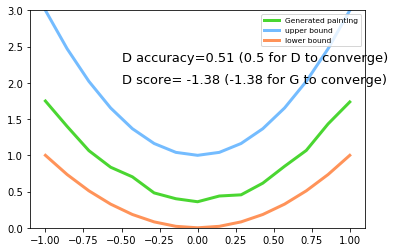

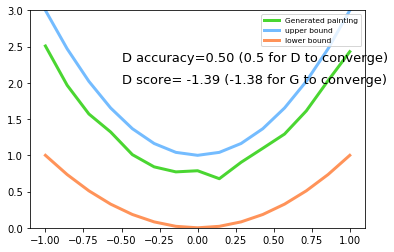

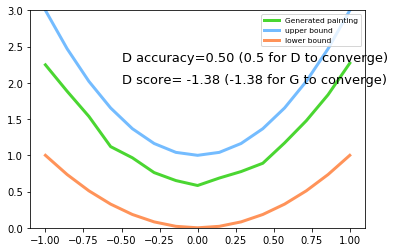

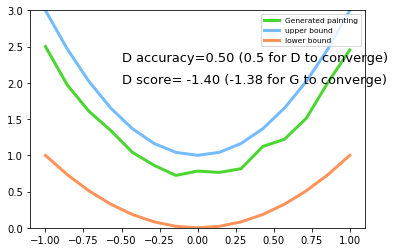

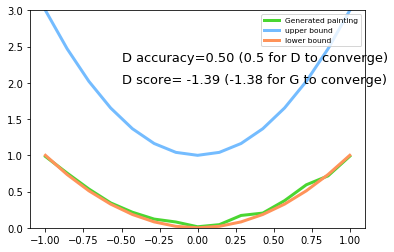

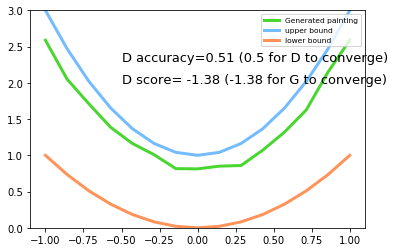

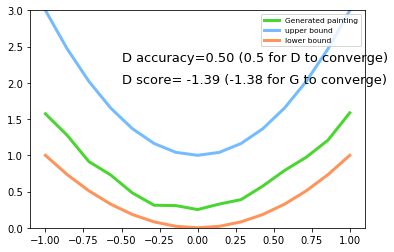

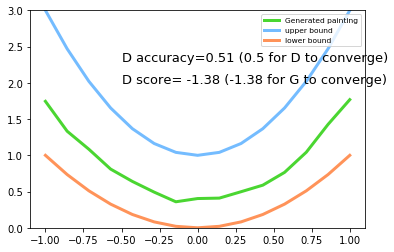

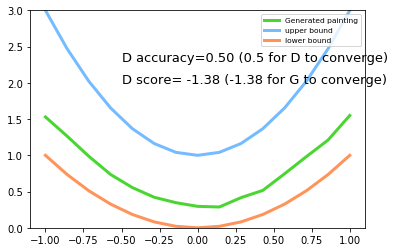

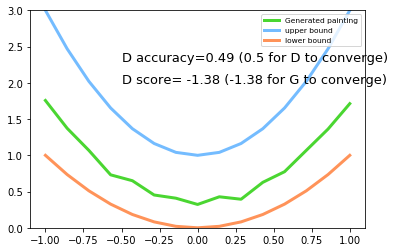

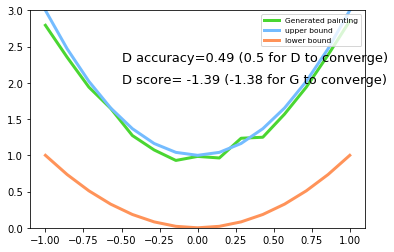

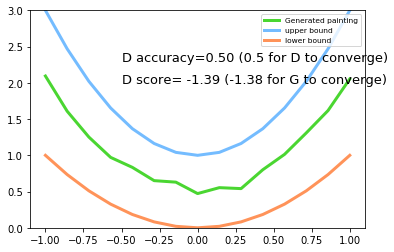

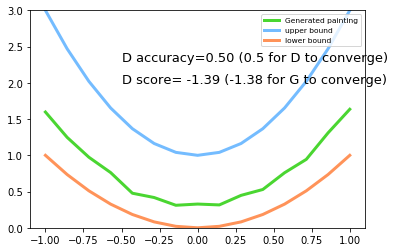

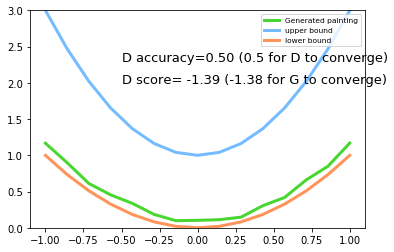

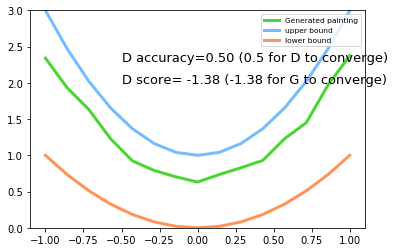

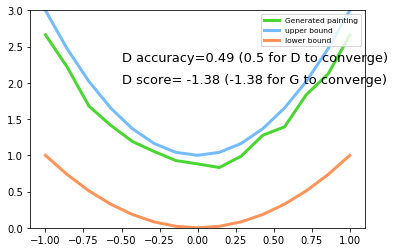

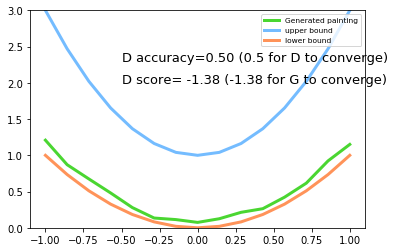

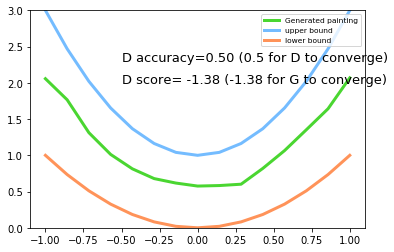

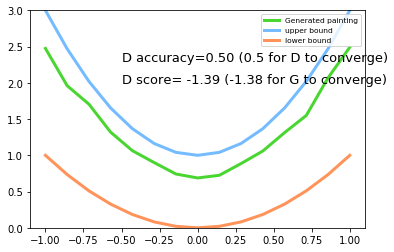

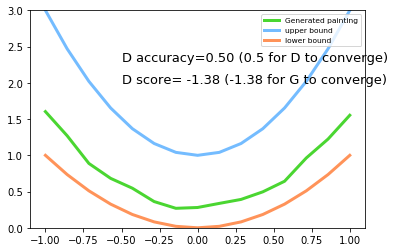

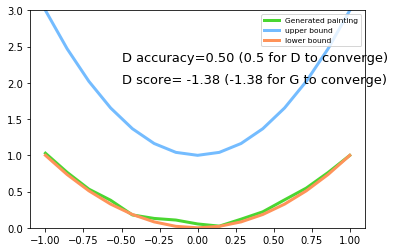

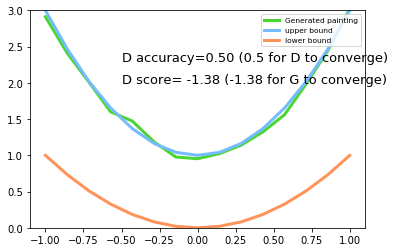

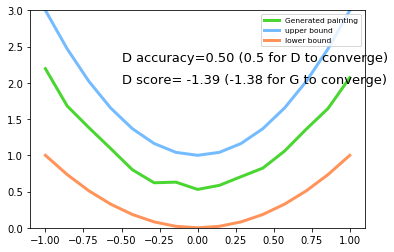

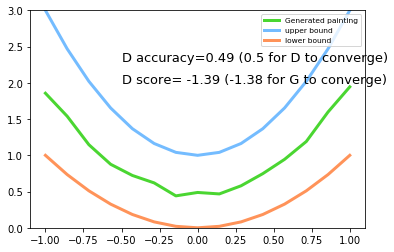

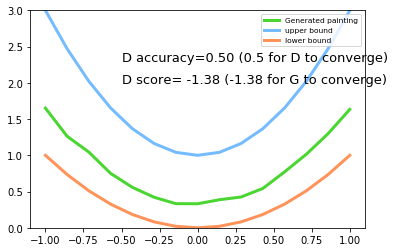

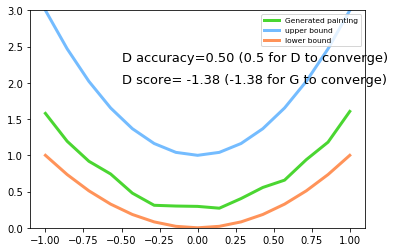

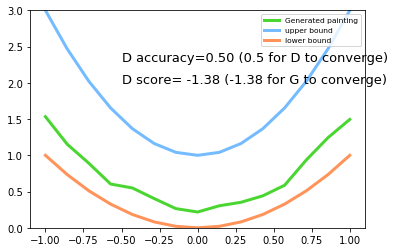

In [45]:
plt.ion()   # something about continuous plotting

for step in range(10000):
    # 著名画家
    artist_paintings = artist_works()
    # 新手画家
    G_ideas = torch.rand(BATCH_SIZE,N_IDEAS)
    G_paintings = G(G_ideas)
    
    # 用新手鉴赏家来比较
    prob_artist0 = D(artist_paintings) #判断这批画里面有多少是著名画家画的
    prob_artist1 = D(G_paintings)    #判断这批画里面有多少是著名画家画的
    
    #计算loss，这里计算loss是自己定义的函数，而不是用torch本身的
    # D_loss就是说，希望prob_artist0都是1，prob_artist1都是0，否则要受到比较大的惩罚，注意有一个负号
    D_loss = -torch.mean(torch.log(prob_artist0)+torch.log(1- prob_artist1))
    # G_loss是说，希望prob_artist1都是1，能生成著名的画，否则要受到比较大的惩罚
    G_loss = torch.mean(torch.log(1-prob_artist1))      #都要用mean，最后的loss是一个数，是对一个BATCH的平均loss

    opt_D.zero_grad()
    D_loss.backward(retain_graph=True)
    opt_D.step()
    
    opt_G.zero_grad()
    G_loss.backward()
    opt_G.step()
    
    if step % 50 == 0:  # plotting
        plt.cla()
        plt.plot(PAINT_POINTS[0], G_paintings.data.numpy()[0], c='#4AD631', lw=3, label='Generated painting',)
        plt.plot(PAINT_POINTS[0], 2 * np.power(PAINT_POINTS[0], 2) + 1, c='#74BCFF', lw=3, label='upper bound')
        plt.plot(PAINT_POINTS[0], 1 * np.power(PAINT_POINTS[0], 2) + 0, c='#FF9359', lw=3, label='lower bound')
        plt.text(-.5, 2.3, 'D accuracy=%.2f (0.5 for D to converge)' % prob_artist0.data.numpy().mean(), fontdict={'size': 13})
        plt.text(-.5, 2, 'D score= %.2f (-1.38 for G to converge)' % -D_loss.data.numpy(), fontdict={'size': 13})
        plt.ylim((0, 3));plt.legend(loc='upper right', fontsize=7.5);plt.draw();plt.pause(0.01)

plt.ioff()
plt.show()